In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import cv2
import glob
import keras
import random
import time
from keras import models
from keras import layers
from keras import regularizers
from PIL import Image
from copy import deepcopy

### Configuration

In [2]:
class_model_dir = 'E:\\Data\\Traffic_Signs_Detection_Models\\tsd_class_v9.h5'
bin_model_dir = 'E:\\Data\\Traffic_Signs_Detection_Models\\tsd_bin_v4.h5'
labels_dir = 'E:\\Data\\Traffic_Signs_Preprocessed_Class\\labels.pickle'

### Preparing env

In [3]:
class_model = keras.models.load_model(class_model_dir)
bin_model = keras.models.load_model(bin_model_dir)
labels = pd.read_pickle(labels_dir)

In [4]:
def decode_one_hot(one_hot):
    return np.where(one_hot == 1)[0][0]

In [5]:
def is_overlapping(box1, box2):
    return (box1[0][0] <= box2[0][0] <= box1[1][0] or box1[0][0] <= box2[1][0] <= box1[1][0] or (box1[0][0] >= box2[0][0] and box1[1][0] <= box2[1][0])) and (box1[0][1] <= box2[0][1] <= box1[1][1] or box1[0][1] <= box2[1][1] <= box1[1][1] or (box1[0][1] >= box2[0][1] and box1[1][1] <= box2[1][1]))

In [6]:
def mark_detections(img, detections, font_scale=0.5, offset=0, thickness=2):
    result = img.copy()
    for detection in detections:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        result = cv2.rectangle(result, detection[0], detection[1], color, thickness)
        result = cv2.putText(result, detection[2], (detection[0][0]-offset, detection[0][1]-5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)
    return result

In [7]:
def create_groups(detections):
    groups = []
    for box in detections:
        if not groups:
            groups.append([deepcopy(box)])
            continue

        intersects_any = False
        for group in groups:
            intersects_all = True
            for group_box in group:
                if not is_overlapping(group_box, box):
                    intersects_all = False
                    break

            if intersects_all:
                group.append(deepcopy(box))
                intersects_any = True

        if not intersects_any:
            groups.append([deepcopy(box)])
    
    boxes = []
    for g in groups:
        point_1 = [0, 0]
        point_2 = [0, 0]
        for b in g:
            point_1[0] += b[0][0]
            point_1[1] += b[0][1]
            point_2[0] += b[1][0]
            point_2[1] += b[1][1]
        point_1[0] = int(point_1[0] / len(g))
        point_1[1] = int(point_1[1] / len(g))
        point_2[0] = int(point_2[0] / len(g))
        point_2[1] = int(point_2[1] / len(g))

        boxes.append((point_1, point_2))
            
    return boxes

In [8]:
def sliding_window_detection(img, size_begin=(8, 8), size_end=(320, 320), size_step=(2, 2), stride=(1, 1), bin_model=bin_model, class_model=class_model, labels=labels, class_threshold=0.001, verbose=1):
    # assertions
    assert img.shape[0] >= size_begin[0]
    assert img.shape[1] >= size_begin[1]
    assert class_model.layers[0].input.shape[0] == bin_model.layers[0].input.shape[0]
    assert class_model.layers[0].input.shape[1] == bin_model.layers[0].input.shape[1]
    assert class_model.layers[0].input.shape[2] == bin_model.layers[0].input.shape[2]
    assert class_model.layers[0].input.shape[3] == bin_model.layers[0].input.shape[3]
    
    # preprocess image
    if img.dtype not in [np.float32, np.float64]:
        img = img.astype('float64') / 255.0
    
    # variables
    model_input = (class_model.layers[0].input.shape)[1:-1]
    detections = []
    time_for_prediction = 0
    time_for_image_preparation = 0
    
    # main loop
    while True:
        if verbose != 0:
            print(f"Detection for window size ({size_begin[0]}, {size_begin[1]})")
        for y in range(0, img.shape[0], stride[0]):
            if y + size_begin[0] > img.shape[0]:
                break
            for x in range(0, img.shape[1], stride[1]):
                if x + size_begin[1] > img.shape[1]:
                    break
                
                # crop & resize & prepare tensor out of the image
                start = time.time()
                cropped = img[y:y+size_begin[0], x:x+size_begin[1]]
                cropped_resized = cv2.resize(cropped, model_input)
                cropped_tensor = np.expand_dims(cropped_resized, axis=0)
                end = time.time()
                time_for_image_preparation += (end - start)
                
                # verify if the cropped image is a traffic sign
                start = time.time()
                bin_result = bin_model.predict(cropped_tensor)[0][0]
                end = time.time()
                time_for_prediction += (end - start)
                
                if bin_result <= class_threshold:                            
                    # get bounding box
                    start_point = (x, y)
                    end_point = (x+size_begin[1], y+size_begin[0])
                    
                    # save bounding box
                    detections.append((start_point, end_point))
                    
                    # log detected sign
                    if verbose != 0:
                        print(f"Detected traffic sign. Begins at: {start_point} Ends at: {end_point}")
                    
        # set new size to the sliding window
        size_begin = (size_begin[0] + size_step[0], size_begin[1] + size_step[1])
        
        # break the loop if the window is too big
        if size_begin[0] > img.shape[0] or size_begin[1] > img.shape[1] or size_begin[0] > size_end[0] or size_begin[1] > size_end[1]:
            break
    
    # process detections & delete colisions
    detections = create_groups(create_groups(detections))
    
    # classify detections
    result = []
    increase = 0.1
    for detection in detections:
        difference = increase*(detection[1][0] - detection[0][0])
        
        top_left = (int(detection[0][0]-difference), int(detection[0][1]-difference))
        bottom_right = (int(detection[1][0]+difference), int(detection[1][1]+difference))
        
        if top_left[0] < 0:
            top_left[0] = 0
            
        if top_left[1] < 0:
            top_left[1] = 0
        
        if bottom_right[0] >= img.shape[1]:
            bottom_right[0] = img.shape[1] - 1
            
        if bottom_right[1] >= img.shape[0]:
            bottom_right[1] = img.shape[0] - 1
        
        cropped = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        cropped_resized = cv2.resize(cropped, model_input)
        cropped_tensor = np.expand_dims(cropped_resized, axis=0)
        label = labels[np.argmax(class_model.predict(cropped_tensor)[0])]
        
        result.append((detection[0], detection[1], label))
        
    return result, (time_for_prediction, time_for_image_preparation)

### Detection

Detection for window size (220, 220)
Detected traffic sign. Begins at: (460, 20) Ends at: (680, 240)
Detected traffic sign. Begins at: (450, 30) Ends at: (670, 250)
Detected traffic sign. Begins at: (460, 30) Ends at: (680, 250)
Detected traffic sign. Begins at: (470, 30) Ends at: (690, 250)
Detected traffic sign. Begins at: (440, 40) Ends at: (660, 260)
Detected traffic sign. Begins at: (450, 40) Ends at: (670, 260)
Detected traffic sign. Begins at: (460, 40) Ends at: (680, 260)
Detected traffic sign. Begins at: (470, 40) Ends at: (690, 260)
Detected traffic sign. Begins at: (480, 40) Ends at: (700, 260)
Detected traffic sign. Begins at: (490, 40) Ends at: (710, 260)
Detected traffic sign. Begins at: (440, 50) Ends at: (660, 270)
Detected traffic sign. Begins at: (450, 50) Ends at: (670, 270)
Detected traffic sign. Begins at: (460, 50) Ends at: (680, 270)
Detected traffic sign. Begins at: (470, 50) Ends at: (690, 270)
Detected traffic sign. Begins at: (480, 50) Ends at: (700, 270)
Det

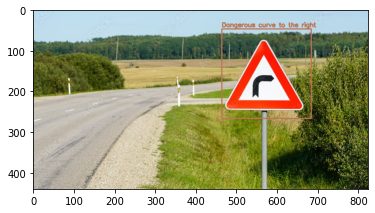

In [9]:
image1 = np.array(Image.open("E:\\Data\\Samples\\road4.jpg"))
detections1, times1 = sliding_window_detection(image1, size_begin=(220, 220), size_end=(220, 220), stride=(10, 10), size_step=(10, 10))
print("Time taken for prediction: " + str(times1[0]) + "s")
print("Time taken for resizing images: " + str(times1[1]) + "s")
plt.imshow(mark_detections(image1, detections1))

Detection for window size (70, 70)
Detected traffic sign. Begins at: (32, 104) Ends at: (102, 174)
Detected traffic sign. Begins at: (40, 104) Ends at: (110, 174)
Detected traffic sign. Begins at: (48, 104) Ends at: (118, 174)
Detected traffic sign. Begins at: (40, 112) Ends at: (110, 182)
Time taken for prediction: 46.023157835006714s
Time taken for resizing images: 0.11296343803405762s


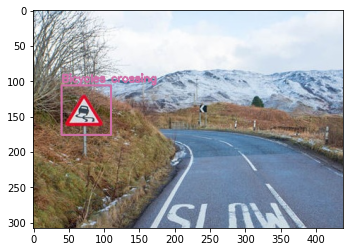

In [10]:
image2 = np.array(Image.open("E:\\Data\\Samples\\road3.jpg"))
detections2, times2 = sliding_window_detection(image2, size_begin=(70, 70), size_end=(70, 70), stride=(8, 8), size_step=(10, 10))
print("Time taken for prediction: " + str(times2[0]) + "s")
print("Time taken for resizing images: " + str(times2[1]) + "s")
plt.imshow(mark_detections(image2, detections2))

Detection for window size (20, 20)
Detected traffic sign. Begins at: (260, 70) Ends at: (280, 90)
Detected traffic sign. Begins at: (265, 70) Ends at: (285, 90)
Detected traffic sign. Begins at: (230, 75) Ends at: (250, 95)
Detected traffic sign. Begins at: (260, 75) Ends at: (280, 95)
Detected traffic sign. Begins at: (265, 75) Ends at: (285, 95)
Detected traffic sign. Begins at: (155, 80) Ends at: (175, 100)
Detected traffic sign. Begins at: (260, 90) Ends at: (280, 110)
Detected traffic sign. Begins at: (270, 90) Ends at: (290, 110)
Detected traffic sign. Begins at: (295, 95) Ends at: (315, 115)
Detected traffic sign. Begins at: (340, 95) Ends at: (360, 115)
Detected traffic sign. Begins at: (355, 95) Ends at: (375, 115)
Detected traffic sign. Begins at: (295, 100) Ends at: (315, 120)
Detected traffic sign. Begins at: (300, 100) Ends at: (320, 120)
Detected traffic sign. Begins at: (355, 100) Ends at: (375, 120)
Detected traffic sign. Begins at: (360, 100) Ends at: (380, 120)
Detect

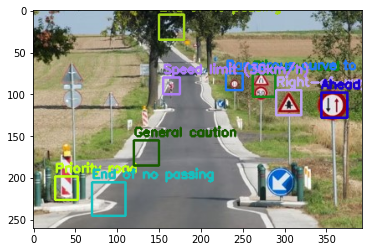

In [15]:
image3 = np.array(Image.open("E:\\Data\\Samples\\road6.jpg"))
detections3, times3 = sliding_window_detection(image3, class_threshold=0.0001, size_begin=(20, 20), size_end=(40, 40), stride=(5, 5), size_step=(10, 10), verbose=1)
print("Time taken for prediction: " + str(times3[0]) + "s")
print("Time taken for resizing images: " + str(times3[1]) + "s")
plt.imshow(mark_detections(image3, detections3))

In [ ]:
image4 = np.array(Image.open("E:\\Data\\Samples\\road7.jpg"))
detections4, times4 = sliding_window_detection(image4, size_begin=(100, 100), size_end=(200, 200), stride=(20, 20), size_step=(20, 20), verbose=0)
print("Time taken for prediction: " + str(times4[0]) + "s")
print("Time taken for resizing images: " + str(times4[1]) + "s")
plt.imshow(mark_detections(image4, detections4))

Detection for window size (50, 50)
Detected traffic sign. Begins at: (288, 56) Ends at: (338, 106)
Detected traffic sign. Begins at: (344, 56) Ends at: (394, 106)
Detected traffic sign. Begins at: (336, 64) Ends at: (386, 114)
Detected traffic sign. Begins at: (344, 64) Ends at: (394, 114)
Detected traffic sign. Begins at: (344, 72) Ends at: (394, 122)
Detected traffic sign. Begins at: (328, 80) Ends at: (378, 130)
Detected traffic sign. Begins at: (336, 80) Ends at: (386, 130)
Detected traffic sign. Begins at: (344, 80) Ends at: (394, 130)
Detected traffic sign. Begins at: (328, 88) Ends at: (378, 138)
Detected traffic sign. Begins at: (336, 88) Ends at: (386, 138)
Detected traffic sign. Begins at: (344, 88) Ends at: (394, 138)
Detection for window size (60, 60)
Detected traffic sign. Begins at: (336, 56) Ends at: (396, 116)
Detected traffic sign. Begins at: (336, 64) Ends at: (396, 124)
Detected traffic sign. Begins at: (336, 72) Ends at: (396, 132)
Detected traffic sign. Begins at: 

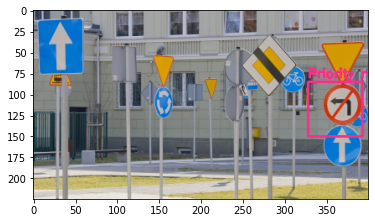

In [11]:
image5 = np.array(Image.open("E:\\Data\\Samples\\road8_2.jpg"))
detections5, times5 = sliding_window_detection(image5, class_threshold=0.01, size_begin=(50, 50), size_end=(130, 130), stride=(8, 8), size_step=(10, 10))
print("Time taken for prediction: " + str(times5[0]) + "s")
print("Time taken for resizing images: " + str(times5[1]) + "s")
plt.imshow(mark_detections(image5, detections5))

In [ ]:
image6 = np.array(Image.open("E:\\Data\\Samples\\road2.jpg"))
detections6, times6 = sliding_window_detection(image6, size_begin=(60, 60), size_end=(100, 100), stride=(10, 10), size_step=(10, 10))
print("Time taken for prediction: " + str(times6[0]) + "s")
print("Time taken for resizing images: " + str(times6[1]) + "s")
plt.imshow(mark_detections(image6, detections6))